In [6]:
import argparse
import numpy as np
from softlearning.environments.adapters.gym_adapter import GymAdapter
import gym
import multiworld
multiworld.register_all_envs()
multiworld.register_mujoco_envs()

import imageio
import pickle
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import skimage

%matplotlib inline

In [ ]:
exp_name = 'test'

In [ ]:
cur_dir = os.getcwd()
directory = os.path.join(cur_dir, exp_name)
if not os.path.exists(directory):
    os.makedirs(directory)
directory

In [27]:
images = True
NUM_TOTAL_EXAMPLES, ROLLOUT_LENGTH, STEPS_PER_SAMPLE = 1, 15, 1
univ = 'gym'
domain = 'Pusher2D'
task = 'Simple-v0'

# === SET GOAL ===
goal_x, goal_y = (2, 2)
eps = 0.15      # Within 0.25 distance
# ================

init_qpos_range = ((goal_x - 2 * eps, goal_y - 2 *eps, -np.pi), (goal_x + 2 * eps, goal_y + 2 * eps, np.pi))
init_pos_range = ((goal_x - eps, goal_y - eps), (goal_x + eps, goal_y + eps))
target_pos_range = ((goal_x, goal_y), (goal_x, goal_y))

env_kwargs = {
    'init_qpos_range': init_qpos_range,
    'init_object_pos_range': init_pos_range,
    'target_pos_range': target_pos_range,
    'observation_keys': ('gripper_qpos', 'gripper_qvel', 'object_pos', 'target_pos'),
    'reset_gripper': True,
    'reset_object': True,
}
env = GymAdapter(
    domain=domain,
    task=task,
    **env_kwargs
) 

In [28]:
observations = []
actions = []
next_observations = []
num_positives = 0

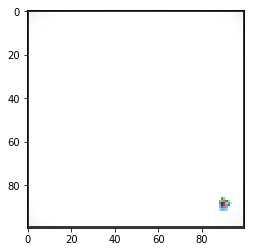

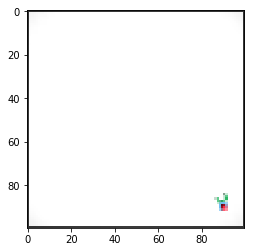

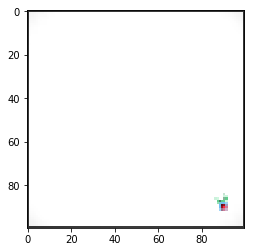

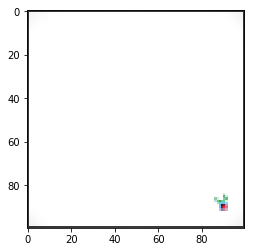

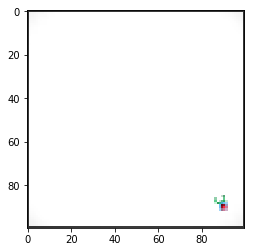

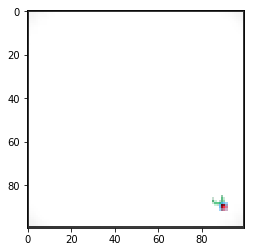

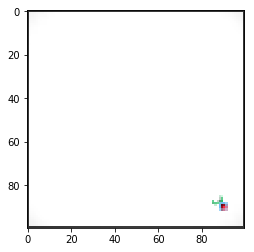

In [29]:
# reset the environment
while num_positives <= NUM_TOTAL_EXAMPLES:
    prev_obs = env.reset()
    last_action = env.action_space.sample()
    for _ in range(STEPS_PER_SAMPLE):
        obs, rew, done, info = env.step(last_action)
        
    t = 0
    while t < ROLLOUT_LENGTH:
        action = env.action_space.sample()
                
        prev_obs = obs
        # === SPECIFY YOUR GOAL CRITERIA ===
        if np.abs(env.unwrapped.compute_reward(action, prev_obs)) < eps:
            observations.append(prev_obs)
            for _ in range(STEPS_PER_SAMPLE):
                obs, rew, done, info = env.step(action)
            plt.imshow(env.render(mode='rgb_array'))
            plt.show()
            next_observations.append(obs)
            actions.append(action)
            num_positives += 1
        else:
            for _ in range(STEPS_PER_SAMPLE):
                obs, rew, done, info = env.step(action)
        last_action = action
        t += 1

In [17]:
goal_obs = {
    key: np.concatenate([
        obs[key][None] for obs in observations
    ], axis=0)
    for key in observations[0].keys()
}
goal_next_obs = {
    key: np.concatenate([
        obs[key][None] for obs in next_observations
    ], axis=0)
    for key in next_observations[0].keys()
}
goal_actions = np.vstack(actions)

goal_transitions = {
    'observations': goal_obs,
    'next_observations': goal_next_obs,
    'actions': goal_actions,
}

In [18]:
goal_obs['state_observation'][0], goal_next_obs['state_observation'][0], goal_actions[0]

KeyError: 'state_observation'

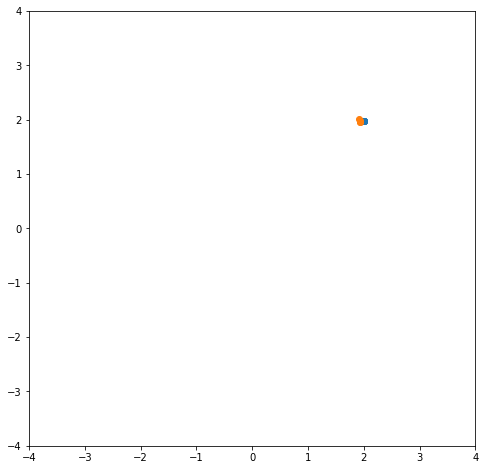

In [20]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.scatter(goal_transitions['observations']['object_pos'][:, 0], goal_transitions['observations']['object_pos'][:, 1])
plt.scatter(goal_transitions['observations']['gripper_qpos'][:, 0], goal_transitions['observations']['gripper_qpos'][:, 1])
plt.show()

In [ ]:
goal_examples = {
    key: np.concatenate([
        obs[key][None] for obs in observations
    ], axis=0)
    for key in observations[0].keys()
}
with open(os.path.join(directory, 'positives.pkl'), 'wb') as file:
    pickle.dump(goal_examples, file)